In [1]:
def clean_Text(data, check):
    if check:
        clean_str = data.str.replace("[^a-zA-Z]", " ")
        clean_str = clean_str.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
        clean_str = clean_str.apply(lambda x: x.lower())
    else:
        clean_str = data.str.replace("[^ㄱ-ㅣ가-힣]", " ")
        
    return clean_str

In [2]:
def isHangul(text):
    pyVer3 =  sys.version_info >= (3, 0)

    if pyVer3 : 
        encText = text
    else: 
        if type(text) is not unicode:
            encText = text.decode('utf-8')
        else:
            encText = text

    hanCount = len(re.findall(u'[\u3130-\u318F\uAC00-\uD7A3]+', encText))
    return hanCount > 0

In [3]:
def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

In [4]:
def get_Jaccard(str1, str2): 
    l = []
    a = set(str1.split())
    for i in range(len(str2)):
        b = set(str2[i].lower().split())
        c = a.intersection(b)
        result = float(len(c)) / (len(a) + len(b) - len(c))
        if result > (len(a)/len(str2[i])+0.17):
            if result == 1:
                return str2[i]
            l.append(str2[i])
    return l

In [5]:
def data_Clean(data):
    
    naver_review = []
    imdb_review = []
    data = data.astype(str)
    for i in range(7):
        naver_review.append(clean_Text(data['review'+str(i+1)],0))
        data['review'+str(i+1)] = naver_review[i]
    data['naver_review'] = (naver_review[0] + naver_review[1] + naver_review[2] 
                            + naver_review[3] + naver_review[4] + naver_review[5] + naver_review[6])
    
    for i in range(5):
        imdb_review.append(clean_Text(data['r'+str(i+1)],1))
        data['r'+str(i+1)] = imdb_review[i]
    data['imdb_review'] =  imdb_review[0] + imdb_review[1] + imdb_review[2] + imdb_review[3] + imdb_review[4]


    return data

In [6]:
def analysis_Similar(data, title_order,review_category):
    tfidf_vect = TfidfVectorizer()
    feature_vect = tfidf_vect.fit_transform(data[review_category])
    similarity = cosine_similarity(feature_vect , feature_vect)
    return find_Title(similarity, title_order)

In [7]:
def analysis_LSA(data, title_order, check):
    if check == 1:
        lsa_data = pd.DataFrame([data['r1'],data['r2'],data['r3'],data['r4'],data['r5']])
        vectorizer = TfidfVectorizer(stop_words='english', 
                                max_features= 1000,
                                max_df = 0.3, 
                                smooth_idf=True)
    else:
        if check == 2:
            lsa_data = pd.DataFrame([data['character'],data['genres'],data['label']])
        else:
            lsa_data = pd.DataFrame([data['review1'],data['review2'],data['review3'],
                                    data['review4'],data['review5'],data['review6'],data['review7']])
        vectorizer = TfidfVectorizer(tokenizer=okt_tokenizer,
                                stop_words=stopwords,
                                max_features=1000,
                                max_df = 0.4,
                                min_df = 0.15,
                                smooth_idf=True)
        
    X = vectorizer.fit_transform(lsa_data[title_order])

    if check == 1:
        svd_model = TruncatedSVD(n_components=12, algorithm='randomized', n_iter=50)
    elif check == 3:
        svd_model = TruncatedSVD(n_components=6, algorithm='randomized', n_iter=50)
    else:
        svd_model = TruncatedSVD(n_components=1, algorithm='randomized', n_iter=50)

    try:
        svd_model.fit(X)
    except:
        svd_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=50)
        svd_model.fit(X)
        
    terms = vectorizer.get_feature_names() 
    text = []
    for idx, topic in enumerate(svd_model.components_): 
              text.append([(terms[i], topic[i].round(5))
              for i in topic.argsort()[:-5 - 1:-1]])
    return text

In [8]:
def analysis_LDA(data, title_order, check):
    if check == 1:
        lda_data = pd.DataFrame([data['r1'],data['r2'],data['r3'],data['r4'],data['r5']])
        vectorizer = TfidfVectorizer(stop_words='english', 
                                max_features= 1000, 
                                max_df = 0.6, 
                                smooth_idf=True)
    else:
        if check == 2:
            lda_data = pd.DataFrame([data['character'],data['genres'],data['label']])
        else:
            lda_data = pd.DataFrame([data['review1'],data['review2'],data['review3'],
                                    data['review4'],data['review5'],data['review6'],data['review7']])
            
        vectorizer = TfidfVectorizer(tokenizer=okt_tokenizer,
                                stop_words=stopwords,
                                max_features=1000,
                                max_df = 0.4,
                                min_df = 0.15,
                                smooth_idf=True)
        
    X = vectorizer.fit_transform(lda_data[title_order])
    lda_model=LatentDirichletAllocation(n_components=5,learning_method='online',max_iter=300)
    lda_top=lda_model.fit_transform(X)
    terms = vectorizer.get_feature_names()
    text = []
    for idx, topic in enumerate(lda_model.components_): 
              text.append([(terms[i], topic[i].round(5))
              for i in topic.argsort()[:-5 - 1:-1]])
    return text

In [9]:
def find_Title(similarity, title_order):
    list_title = []
    find = similarity[:][title_order]
    return find.argsort()[::-1][1:6]

In [10]:
def word_Embedding(data, origin_data, list_data, check):
    orign_lsa = analysis_LSA(data, origin_data, check)
    orign_lda = analysis_LDA(data,origin_data, check)
    list_lsa = analysis_LSA(data,list_data, check)
    list_lda = analysis_LDA(data,list_data, check)
    
    word_origin = pd.DataFrame(orign_lsa[0])
    word_origin = word_origin.append(pd.DataFrame(orign_lda[0]))
    
    word_test = pd.DataFrame(list_lsa[0])
    word_test = word_test.append(pd.DataFrame(list_lda[0]))
    
    for i in range(1,len(orign_lsa)):
        word_origin = word_origin.append(pd.DataFrame(orign_lsa[i]))
        word_test = word_test.append(pd.DataFrame(list_lsa[i]))
        
    for j in range(1,len(orign_lda)):
        word_origin = word_origin.append(pd.DataFrame(orign_lda[j]))
        word_test = word_test.append(pd.DataFrame(list_lda[j]))
                                         
    word = pd.merge(word_origin,word_test,how='outer')
    model = Word2Vec(size=6, window=1, min_count=1, workers=5)
    model.build_vocab(word[0])
    model.train(word[0], total_examples=model.corpus_count, epochs=80, report_delay=1)
    word_vectors = model.wv
    vocabs = word_vectors.vocab.keys()
    
    return word_vectors[vocabs].sum(), word
        

In [11]:
def get_WordError(data, title, list_work, check):
    emb = []
    sum_vector = 0
    try:
        if type(list_work) == np.int64:
            value = word_Embedding(data, title, list_work, check)
            sum_vector += value[0]
            emb.append(value)
            return emb, sum_vector
        else:

            for i in range(len(list_work)):
                value = word_Embedding(data, title, list_work[i], check)
                sum_vector += value[0]
                emb.append(value)
    except:
        return emb, sum_vector
    
    sum_vector /= len(list_work)
    return emb, sum_vector

In [12]:
def ranking_List(list_rank, sum_v, n_l, imdb_emb, naver_emb):
    result_netflix_list = []
    check = 0
    for i in range(5):
        try:
            i_list = (abs(sum_v*n_l[i][0]*imdb_emb[i][0])) / abs(imdb_emb[i][0]+n_l[i][0])**0.5
            check=1
            n_list = (abs(sum_v*n_l[i][0]*naver_emb[i][0])) / abs(naver_emb[i][0]+n_l[i][0])**0.5

            if abs(sum_v*0.5)< i_list < abs(sum_v*1.5):
                result_netflix_list.append(list_rank[i*2])

            if abs(sum_v*0.5)< n_list < abs(sum_v*1.5):
                result_netflix_list.append(list_rank[i*2+1])
        except:
            continue
            
    return result_netflix_list

In [13]:
def get_Strat():
    hangle_check = 0
    
    data =pd.read_csv('final_data2.csv', encoding='utf-8')
    data = data_Clean(data)
    
    while(1):
        print("제목을 입력하세요 : ")
        user_input_title = input()
        if isHangul(user_input_title):
            hangle_check = 1
            title = get_Jaccard(user_input_title,data['title_y'])
        else:
            title = get_Jaccard(user_input_title,data['title_x'])
        

        if type(title) == list:
            
            if len(title) == 0:
                print('%s 검색된 작품이 없습니다.' %user_input_title)
                continue
            else:
                print('다음의 작품들이 검색되었습니다. 작품번호를 입력하세요.')
                for i in range(len(title)): 
                    print("%d.%s" %(i+1,title[i]))
                user_input_title = int(input())
                
                if user_input_title>0 and user_input_title<=len(title):
                    title = title[user_input_title-1]
                    print('%s 비슷한 작품을 찾습니다.' %title)
                    
                    break
                else:
                    continue
                
        else:
            print('%s와 비슷한 작품을 찾습니다.' %user_input_title)
            break
    
    if hangle_check:
        origin = data[data['title_y'].isin([title])].index[0]
    else:
        origin = data[data['title_x'].isin([title])].index[0]
        
    list_work = analysis_Similar(data, origin, 'imdb_review')
    list_work2 = analysis_Similar(data, origin, 'naver_review')
    list_rank = []
    for i in range(5):
        list_rank.append(list_work[i])
        list_rank.append(list_work2[i])
        
    imb_emb, imb_sum_v = get_WordError(data, origin, list_work, 1)
    nav_emb, nav_sum_v = get_WordError(data, origin, list_work2, 3)
    result_emb, result_sum_v = get_WordError(data, origin, list_rank, 2)
    
    final_list = ranking_List(list_rank, result_sum_v, result_emb, imb_emb, nav_emb)
    
    return data, final_list,  get_WordError(data, origin, origin, 3), get_WordError(data, origin, origin, 1), list_rank


In [14]:
def wordCloud(keywords):
    %matplotlib inline

    font_path = '/Users/studio/Library/Jupyter/NanumBarunGothic.ttf'

    netflix_mask = np.array(Image.open("youtube.png"))

    wordcloud = WordCloud(
        font_path = font_path,
        width = 800,
        height = 800,
        background_color='white',
        mask = netflix_mask
    )

    wordcloud = wordcloud.generate_from_frequencies(keywords)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
import re
from konlpy.tag import Okt
import warnings
import sys
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
okt = Okt()

In [16]:
f = open("koreanstopwords.txt", 'r')
lines = f.readlines()
stopwords = []
for line in lines:
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()

제목을 입력하세요 : 
어바웃 타임
어바웃 타임와 비슷한 작품을 찾습니다.


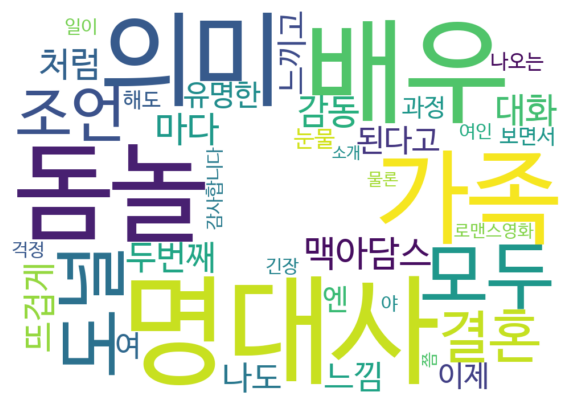

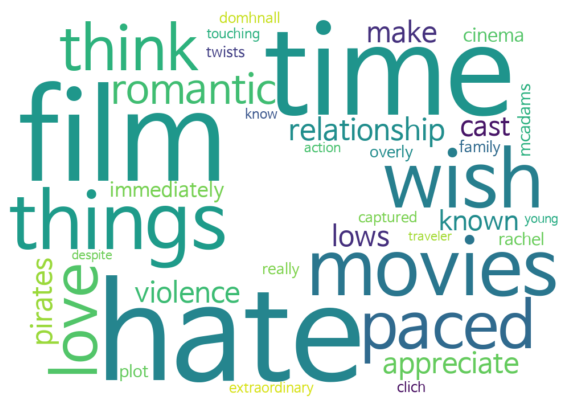

제목 :  지금, 만나러 갑니다
장르 :  영화 도서 원작 판타지드라마 장르 영화로맨스 영화일본 영화드라마 장르 영화 로맨스판타지 영화
------------------------------------------------------
제목 :  노트북
장르 :  영화 도서 원작미국 영화인기 로맨스드라마 장르 영화로맨스 영화드라마 장르 영화 로맨스
------------------------------------------------------
제목 :  미드나잇 인 파리
장르 :  미국 영화인기 로맨스코미디로맨틱 코미디로맨스 영화
------------------------------------------------------
제목 :  사랑하기 때문에
장르 :   판타지로맨스 엉뚱하고 기발코미디한국 영화판타지 영화로맨틱 코미디로맨스 영화
------------------------------------------------------
제목 :  어바웃 타임
장르 :  로맨틱 코미디 판타지인기 로맨스코미디판타지 영화영국 영화로맨스 영화
------------------------------------------------------
제목 :  어바웃 타임
장르 :  로맨틱 코미디 판타지인기 로맨스코미디판타지 영화영국 영화로맨스 영화
------------------------------------------------------
제목 :  멈추고 싶은 순간 : 
어바웃 타임
장르 :  한국 드라마음악 뮤지컬
------------------------------------------------------
제목 :  멈추고 싶은 순간 : 
어바웃 타임
장르 :  한국 드라마음악 뮤지컬
------------------------------------------------------


In [17]:
data, netflix_list, word_ko, word_en,  list_rank = get_Strat()

dict_keywords_ko = dict(zip(word_ko[0][0][1].to_dict()[0].values(),word_ko[0][0][1].to_dict()[1].values()))
wordCloud(dict_keywords_ko)

dict_keywords_en = dict(zip(word_en[0][0][1].to_dict()[0].values(),word_en[0][0][1].to_dict()[1].values()))
wordCloud(dict_keywords_en)

if len(netflix_list) > 3: 
    netflix_list = list(set(netflix_list))
    genres = clean_Text(data.loc[netflix_list[:]]['genres'],0)
    for i in range(len(netflix_list)):
        print('제목 : ',data.loc[netflix_list[i]]['title_y'])
        print('장르 : ',str(genres[netflix_list[i]]).replace('  ', ''))
        print('------------------------------------------------------')
else:
    list_rank = list(set(list_rank))
    genres = clean_Text(data.loc[list_rank[:]]['genres'],0)
    for i in range(len(list_rank)):
        print('제목 : ',data.loc[list_rank[i]]['title_y'])
        print('장르 : ',str(genres[list_rank[i]]).replace('  ', ''))
        print('------------------------------------------------------')

    
